# Exploratory Data Analysis using Covid19-data

## 1. Environment

In [1]:
# import modules
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import zipfile
import os
import sys

In [2]:
# python version
pd.DataFrame(
    {'version': [f'{sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}']}, 
    index=['python']
)

,version
python,3.9.7


In [3]:
# module versions
modules = ['pandas', 'geopandas', 'matplotlib', 'requests']
pd.DataFrame({'version': [sys.modules[m].__version__ for m in modules]}, index=modules)

,version
pandas,1.3.4
geopandas,0.10.2
matplotlib,3.5.0
requests,2.26.0


## 2. Read data

### covid counts per day

In [4]:
# set url
base_url = 'https://data.rivm.nl/covid-19/'

In [5]:
# read data
file_name = 'COVID-19_aantallen_gemeente_per_dag.csv  '

covid = pd.read_csv(
    base_url + file_name, 
    parse_dates = ['Date_of_publication'], 
    index_col = ['Date_of_publication'], 
    sep = ';'
).drop(
    columns = [
        'Date_of_report', 
        'Province', 
        'Security_region_code', 
        'Security_region_name', 
        'Municipal_health_service'
    ]
)

In [6]:
# sample data
covid.sample(n=7)

,Municipality_code,Municipality_name,ROAZ_region,Total_reported,Hospital_admission,Deceased
Date_of_publication,,,,,,
2020-08-30,GM0473,Zandvoort,Netwerk Acute Zorg Noordwest,3,0,0
2020-07-24,GM1721,Bernheze,Netwerk Acute Zorg Brabant,0,0,0
2020-10-30,GM1742,Rijssen-Holten,Acute Zorg Euregio,44,0,0
2021-05-11,NaN,NaN,SpoedZorgNet,0,0,0
2021-05-03,GM1900,Súdwest-Fryslân,Acute Zorgnetwerk Noord Nederland,58,0,0
2021-04-03,GM0569,Nieuwkoop,Netwerk Acute Zorg West,16,0,0
2020-06-17,GM0622,Vlaardingen,Traumacentrum Zuidwest-Nederland,2,0,0


In [7]:
# check na
covid.isna().sum()

Municipality_code     16200
Municipality_name     16200
ROAZ_region            3888
Total_reported            0
Hospital_admission        0
Deceased                  0
dtype: int64

In [8]:
# check for missing ROAZ regions where municipality is not missing (if none, all na's can be dropped safely)
covid[~covid['Municipality_name'].isna() & covid['ROAZ_region'].isna()].shape[0] == 0

True

In [9]:
# drop null values
covid.dropna(axis=0, inplace=True)

In [10]:
# shape
covid.shape

(228744, 6)

In [11]:
# number of (unique) days
days = covid.index.unique().size
days

648

In [12]:
# number of (unique) municipalities
municipalities = covid.Municipality_name.unique().size
municipalities

352

In [13]:
# expected number of rows
days * municipalities

228096

In [14]:
# difference (expected one row per day)
if covid.shape[0] - (days * municipalities) != 0:
    print(covid.shape[0] - (days * municipalities))
else:
    print('No difference found, number of rows as expected:', covid.shape[0])

648


In [15]:
# count total number of rows per municipality
covid.Municipality_name.value_counts()

Amsterdam        1296
Groningen         648
Landgraaf         648
Zundert           648
Woensdrecht       648
                 ... 
Haarlem           648
Enkhuizen         648
Edam-Volendam     648
Diemen            648
Eemsdelta         648
Name: Municipality_name, Length: 352, dtype: int64

In [16]:
# show data for Amsterdam (seems to be separated in 2 ROAZ regions)
covid[covid['Municipality_name'] == 'Amsterdam'].tail(10)

,Municipality_code,Municipality_name,ROAZ_region,Total_reported,Hospital_admission,Deceased
Date_of_publication,,,,,,
2021-12-02,GM0363,Amsterdam,Netwerk Acute Zorg Noordwest,453,1,2
2021-12-02,GM0363,Amsterdam,SpoedZorgNet,360,1,0
2021-12-03,GM0363,Amsterdam,Netwerk Acute Zorg Noordwest,632,0,4
2021-12-03,GM0363,Amsterdam,SpoedZorgNet,495,2,0
2021-12-04,GM0363,Amsterdam,Netwerk Acute Zorg Noordwest,427,2,2
2021-12-04,GM0363,Amsterdam,SpoedZorgNet,389,1,1
2021-12-05,GM0363,Amsterdam,Netwerk Acute Zorg Noordwest,385,2,0
2021-12-05,GM0363,Amsterdam,SpoedZorgNet,311,4,2
2021-12-06,GM0363,Amsterdam,Netwerk Acute Zorg Noordwest,329,2,0


In [17]:
# sum municipality data
covid = covid.reset_index()\
.groupby(by=['Date_of_publication', 'Municipality_code', 'Municipality_name']).sum()\
.reset_index().set_index('Date_of_publication')
covid.tail()

,Municipality_code,Municipality_name,Total_reported,Hospital_admission,Deceased
Date_of_publication,,,,,
2021-12-06,GM1966,Het Hogeland,29,0,0
2021-12-06,GM1969,Westerkwartier,59,0,0
2021-12-06,GM1970,Noardeast-Fryslân,58,0,0
2021-12-06,GM1978,Molenlanden,57,0,0
2021-12-06,GM1979,Eemsdelta,36,0,0


In [18]:
# difference (expected one row per day)
if covid.shape[0] - (days * municipalities) != 0:
    print(covid.shape[0] - (days * municipalities))
else:
    print('No difference found, number of rows as expected:', covid.shape[0])

No difference found, number of rows as expected: 228096


### polygons and municipality data

In [19]:
# download and extract zipped shapefile when shapefile does not exist
if not os.path.isfile('WijkBuurtkaart_2021_v1/gemeente_2021_v1.shp'):
    
    # request zipfile with maps
    url = 'https://www.cbs.nl/-/media/cbs/dossiers/nederland-regionaal/wijk-en-buurtstatistieken/wijkbuurtkaart_2021_v1.zip'
    r = requests.get(url, allow_redirects=True)
    
    # write zipfile
    file_name = url.split('/')[-1]
    open(file_name, 'wb').write(r.content)
    
    # extract zipfile in current folder
    with zipfile.ZipFile(file_name, 'r') as zipObj:
        zipObj.extractall()

In [20]:
# read shapefile
municipality = gpd.read_file('WijkBuurtkaart_2021_v1/gemeente_2021_v1.shp')

In [21]:
# select land
municipality = municipality[municipality['H2O'] == 'NEE'].drop(['H2O'], axis=1)

In [22]:
# sample data
municipality.sample(n=3)

,GM_CODE,GM_NAAM,OAD,STED,BEV_DICHTH,AANT_INW,AANT_MAN,AANT_VROUW,P_00_14_JR,P_15_24_JR,...,P_TURKIJE,P_OVER_NW,OPP_TOT,OPP_LAND,OPP_WATER,JRSTATCODE,JAAR,Shape_Leng,Shape_Area,geometry
248,GM0575,Noordwijk,1399,3,755,44062,22128,21934,15,11,...,0,4,7494,5837,1657,2021GM0575,2021,38165.650634,5.936356e+07,"POLYGON ((96577.364 481505.350, 97460.781 4811..."
339,GM0971,Stein,905,4,1180,24875,12305,12570,12,10,...,0,2,2280,2108,172,2021GM0971,2021,30709.666925,2.279979e+07,"POLYGON ((183070.879 336692.578, 182926.452 33..."
218,GM0448,Texel,483,5,84,13656,6763,6893,13,10,...,0,4,46316,16200,30116,2021GM0448,2021,116824.878131,1.645934e+08,"MULTIPOLYGON (((115618.891 572324.492, 115618...."


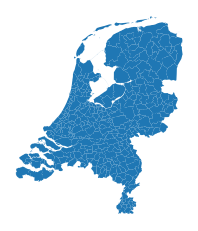

In [23]:
# show municipality map
municipality.plot()
plt.axis('off')
plt.show()

## 3. Wrangle data

In [24]:
# add column 'Total reported per 100.000'
AANT_INW = {k: v for k, v in municipality[['GM_CODE', 'AANT_INW']].values}

covid['Total_reported_100k'] = \
[v * 100_000 / AANT_INW[k] for (k, v) in covid[['Municipality_code', 'Total_reported']].values]

In [25]:
covid.tail()

,Municipality_code,Municipality_name,Total_reported,Hospital_admission,Deceased,Total_reported_100k
Date_of_publication,,,,,,
2021-12-06,GM1966,Het Hogeland,29,0,0,60.626333
2021-12-06,GM1969,Westerkwartier,59,0,0,92.653664
2021-12-06,GM1970,Noardeast-Fryslân,58,0,0,127.525780
2021-12-06,GM1978,Molenlanden,57,0,0,129.163834
2021-12-06,GM1979,Eemsdelta,36,0,0,78.969882


## 4. Visualize data

### 4.1 Time Series

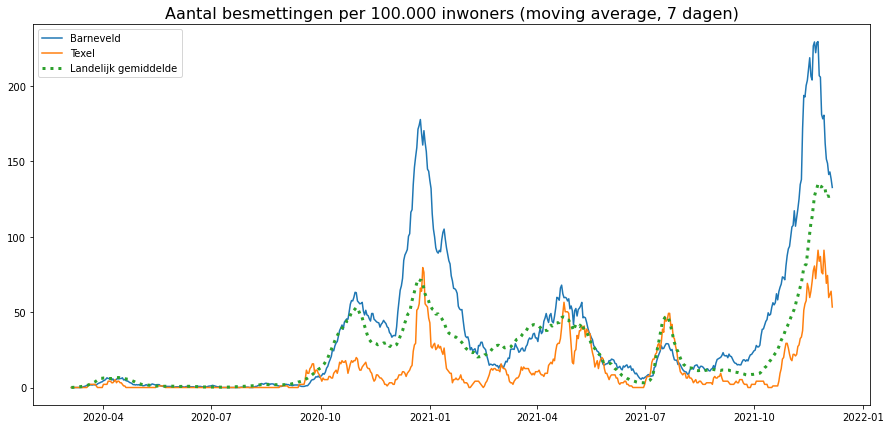

In [26]:
# municipalities to compare
municipalities = ['Barneveld', 'Texel']

# landelijk gemiddelde
country_mean = covid.groupby(by=covid.index).mean()

# moving average in days
ma = 7

# linewidth
lw = 1.5

# plot timeline
fig, ax = plt.subplots(figsize=(15, 7))
for key, values in covid[covid['Municipality_name'].isin(municipalities)].groupby('Municipality_name'):
    ax.plot(values.index, values.Total_reported_100k.rolling(ma).mean(), label=key, linewidth=lw)

ax.plot(
    country_mean.index, country_mean.Total_reported_100k.rolling(ma).mean(), 
    label='Landelijk gemiddelde', linewidth=lw*2, linestyle='dotted')

ax.set_title(f'Aantal besmettingen per 100.000 inwoners (moving average, {ma} dagen)',fontsize=16)
plt.legend()
plt.show()

In [27]:
# different solution, same outcome
pivot = pd.pivot_table(
    covid.reset_index(), 
    values='Total_reported_100k', 
    index='Date_of_publication', 
    columns='Municipality_name')

pivot.tail(n=7)

Municipality_name,'s-Gravenhage,'s-Hertogenbosch,Aa en Hunze,Aalsmeer,Aalten,Achtkarspelen,Alblasserdam,Albrandswaard,Alkmaar,Almelo,...,Zeist,Zevenaar,Zoetermeer,Zoeterwoude,Zuidplas,Zundert,Zutphen,Zwartewaterland,Zwijndrecht,Zwolle
Date_of_publication,,,,,,,,,,,,,,,,,,,,,
2021-11-30,103.224395,136.986301,82.680420,131.286924,106.932153,129.032258,124.155741,139.459208,131.942928,86.145600,...,169.118891,129.263425,161.255558,101.775416,86.543582,131.890122,187.067407,96.393989,129.536572,139.402341
2021-12-01,73.861978,145.990096,51.183117,150.042199,106.932153,121.863799,139.054430,139.459208,42.767708,77.941257,...,95.321557,99.782293,66.258472,124.392175,128.705841,145.533928,106.004864,105.157078,120.603015,117.067160
2021-12-02,97.023636,180.075889,74.806095,103.154012,99.557522,204.301075,198.649186,193.693345,139.222538,120.330362,...,84.559445,70.301161,118.147637,169.625693,99.857980,127.342187,143.418345,96.393989,256.839754,126.309304
2021-12-03,86.081121,144.703839,62.994606,156.293958,77.433628,139.784946,168.851808,123.963741,167.431026,108.023847,...,126.070446,86.175617,98.190266,192.242452,155.334635,118.246316,162.125086,131.446348,187.604690,113.986445
2021-12-04,116.537788,165.283941,86.617583,121.909287,92.182891,125.448029,64.560985,89.098939,135.582733,116.228190,...,184.493335,54.426705,110.164688,260.092729,148.677437,118.246316,112.240444,39.433904,134.003350,137.861984
2021-12-05,107.054275,156.280147,51.183117,125.035166,117.994100,161.290323,188.716726,139.459208,181.990245,131.269485,...,173.731224,124.727866,136.508418,158.317313,99.857980,122.794251,143.418345,39.433904,183.137912,93.191620
2021-12-06,102.677269,181.362145,55.120280,134.412804,106.932153,150.537634,59.594756,73.603471,147.412099,116.228190,...,109.158557,74.836720,121.340816,135.700554,150.896503,136.438057,137.182765,48.196994,113.902848,102.433765


In [28]:
# add country mean
pivot['Landelijk gemiddelde'] = pivot.mean(axis=1)

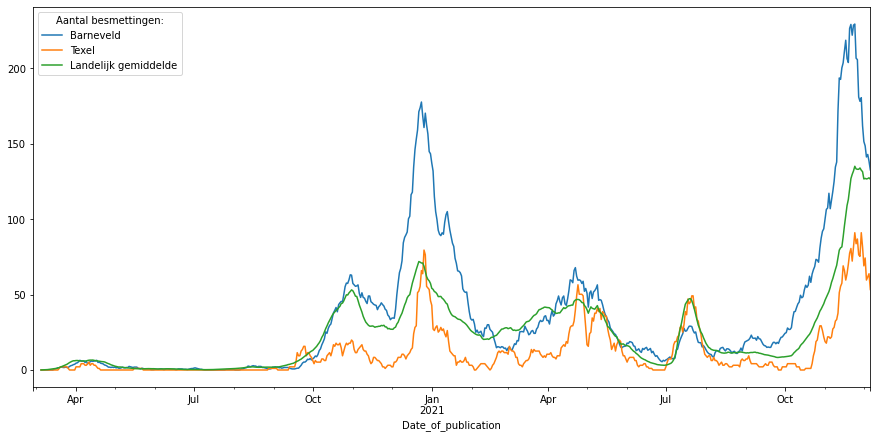

In [29]:
# plot timeline
pivot[['Barneveld', 'Texel', 'Landelijk gemiddelde']].rolling(ma).mean().plot(figsize=(15, 7))
plt.legend(title='Aantal besmettingen:')
plt.show()

In [30]:
import math
assert sum(
    [
        not math.isclose(x, y) for x, y in zip(
            pivot['Landelijk gemiddelde'].values, 
            covid.Total_reported_100k.groupby(covid.index).mean().values
        )
    ]
) == 0

### 4.2 Thematic maps

In [31]:
# most recent date
most_recent = max(covid.index).strftime('%B %d, %Y')
print(most_recent)

December 06, 2021


In [32]:
# geo dataframe
gdf = pd.merge(
    municipality, 
    covid[covid.index == most_recent], # select most recent date
    how='left', 
    left_on='GM_CODE', 
    right_on='Municipality_code'
)

In [33]:
gdf.sample(n=3)

,GM_CODE,GM_NAAM,OAD,STED,BEV_DICHTH,AANT_INW,AANT_MAN,AANT_VROUW,P_00_14_JR,P_15_24_JR,...,JAAR,Shape_Leng,Shape_Area,geometry,Municipality_code,Municipality_name,Total_reported,Hospital_admission,Deceased,Total_reported_100k
138,GM0453,Velsen,1865,2,1518,68617,34099,34518,15,12,...,2021,65336.172138,4.946432e+07,"MULTIPOLYGON (((100000.000 497691.970, 99900.8...",GM0453,Velsen,61,0,0,88.899252
282,GM1681,Borger-Odoorn,264,5,93,25598,12812,12786,14,10,...,2021,67658.308208,2.778915e+08,"POLYGON ((260214.715 555704.692, 260319.813 55...",GM1681,Borger-Odoorn,15,0,0,58.598328
169,GM0597,Ridderkerk,1727,2,1968,46671,22567,24104,15,10,...,2021,22829.621144,2.526286e+07,"POLYGON ((99937.000 434728.000, 100083.000 434...",GM0597,Ridderkerk,33,0,1,70.707720


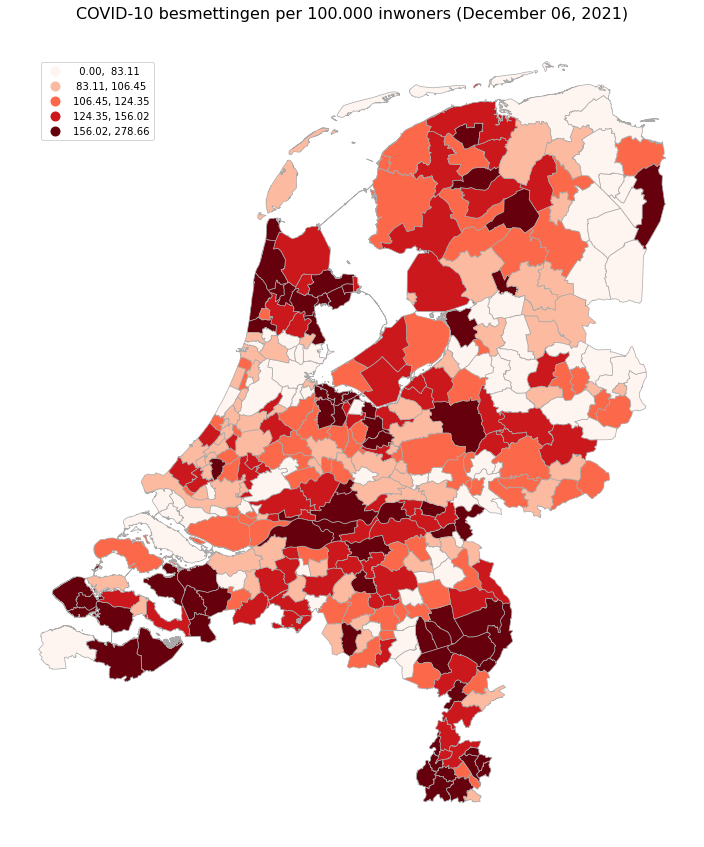

In [34]:
# plot map
column = 'Total_reported_100k'
title = f'COVID-10 besmettingen per 100.000 inwoners ({most_recent})'

# Quantiles
f, ax = plt.subplots(1, figsize=(15, 15))

ax = gdf[~pd.isnull(gdf[column])].plot(
    ax=ax, 
    linewidth=.7, 
    edgecolor='darkgrey', 
    cmap='Reds', # plasma, magma 
    column=column, 
    legend=True, 
    scheme='quantiles', 
)

ax.set_title(title, fontsize=16)
legend = ax.get_legend()
legend.set_bbox_to_anchor((0.22, -0.04, 0, 1))
plt.axis('off')
plt.show()

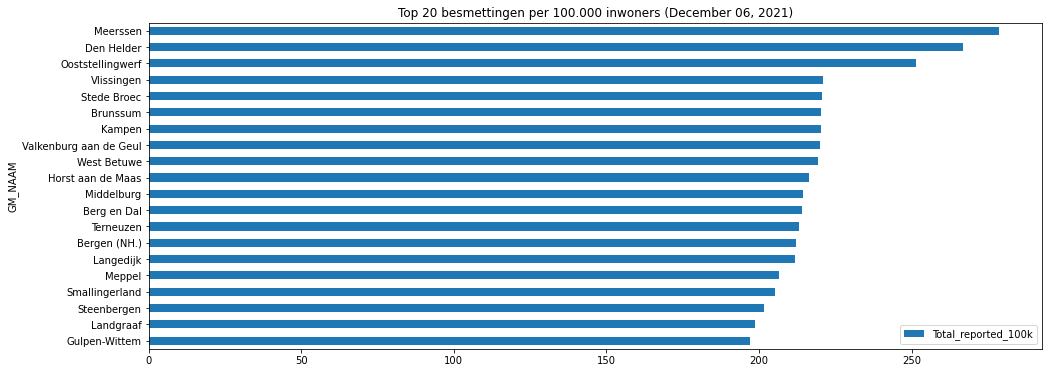

In [35]:
n = 20

gdf\
.nlargest(n, 'Total_reported_100k')\
.sort_values(by='Total_reported_100k', ascending=True)\
.plot(
    kind='barh', 
    x='GM_NAAM', 
    y='Total_reported_100k', 
    figsize=(16, 6), 
    title=f'Top {n} besmettingen per 100.000 inwoners ({most_recent})'
)
plt.show()